<a href="https://colab.research.google.com/github/Jahan08/CNN-Deep-Learning-with-tensorflow/blob/main/CNN_flowers_Image_recognition_without_and_with_data_augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Packages

Let's start by importing required packages. **os** package is used to read files and directory structure, **numpy** is used to convert python list to numpy array and to perform required matrix operations and **matplotlib.pyplot** is used to plot the graph and display images in our training and validation data.

In [ ]:
import os
import numpy as np
import glob
import shutil

import tensorflow as tf

import matplotlib.pyplot as plt

### TODO: Import TensorFlow and Keras Layers

In the cell below, import Tensorflow as `tf` and the Keras layers and models you will use to build your CNN. Also, import the `ImageDataGenerator` from Keras so that you can perform image augmentation.

In [ ]:
#import packages
#Tensorflow libs
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

# Data Loading

In [ ]:
import pathlib
#Declare url
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
#Create a file and download it with Keras utils
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
# get dataset path
data_dir = pathlib.Path(data_dir)

228813984/228813984 [==============================] - 1s 0us/step


In [ ]:
#get image count
image_count = len(list(data_dir.glob('*/*.jpg')))
print("Total Images:",image_count)


Total Images: 3670


 random rose image

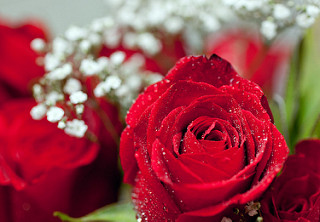

In [ ]:
#get all images in rose file
roses = list(data_dir.glob('roses/*'))
# show third image
PIL.Image.open(str(roses[10]))

random tulips image

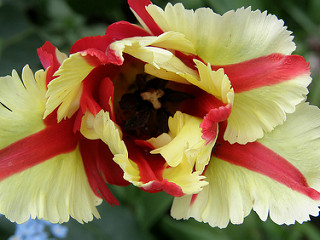

In [ ]:
#get all images in tulips file
tulips = list(data_dir.glob('tulips/*'))
PIL.Image.open(str(tulips[3]))

We will use tf.keras.utils.image_dataset_from_directory this utils for loading datset from directory. As you know, we have just downloaded the dataset to its own directory.

Okay, define the some parameter for loader

In [ ]:
# Batch size
batch_size = 32
# image height
img_height = 180
# image width
img_width = 180

Use 80% of the images for training and 20% for validation.

We will create two separate sets for Train and Validation.

For train:

In [ ]:
# split dataset for train
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


For Validation:

In [ ]:
# split dataset for validation
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 3670 files belonging to 5 classes.
Using 734 files for validation.


If we want to see class tunes. We will see them in alphabetical order

In [ ]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


After performing the dataset separation operations, now we can visualize and take part in our dataset.

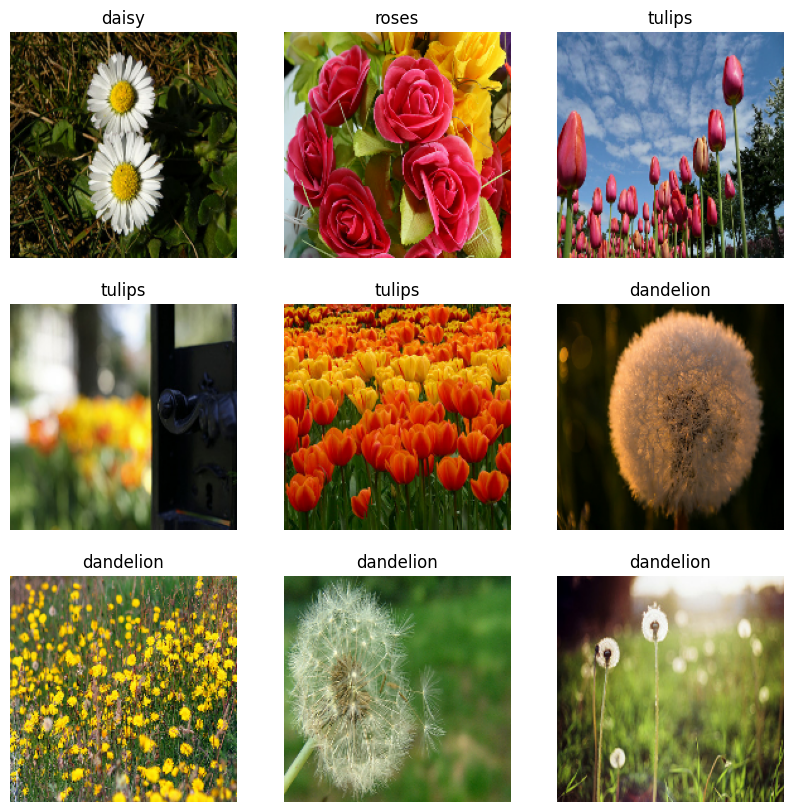

In [ ]:
# determine figure size as 10 by 10
plt.figure(figsize=(10, 10))
# take image from train_ds
for images, labels in train_ds.take(2):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    # plot image using imshow
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

now check the images shapes

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


The image_batch is a tensor of the shape (32, 180, 180, 3). This is a batch of 32 images of shape 180x180x3 (the last dimension refers to color channels RGB). The label_batch is a tensor of the shape (32,), these are corresponding labels to the 32 images.

this part is important, now there are two different ways to ensure all images are buffered before model training; so you can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data:

Dataset.cache keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.
Dataset.prefetch overlaps data preprocessing and model execution while training.

"Dataset.prefetch" is a method in TensorFlow, a popular machine learning library, that allows for efficient data loading during training. When using the prefetch method, the data is loaded from storage into memory in advance of when it will be needed, so that it is ready for use when the training algorithm requests it. This can help to reduce the amount of time spent waiting for data to be loaded during training and can therefore improve overall training performance.

In [ ]:
#Create autotune object
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Standardize the image:

RGB channel values are in the range of [0, 255]. This is not ideal for a neural network and can be tiring, in general you should try to make your input values quite small so that it is easy to handle for a neural network.
based on this we will standardize the values to be in the range [0, 1] using tf.keras.layers:

In [ ]:
# Create a normalization layer
normalization_layer = layers.Rescaling(1./255)

In [ ]:
#normalize dataser using with norm. layer
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
# sparete as image and label
image_batch, labels_batch = next(iter(normalized_ds))
# check the first image max and min value
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print("minumum value:",np.min(first_image), "maximum values: ",np.max(first_image))

minumum value: 0.0 maximum values:  0.9918303


#**Create model without augmentation and dropout**




Keras Sequential model consists of Four convolution blocks

In [ ]:
# get class names
num_classes = len(class_names)

model = tf.keras.models.Sequential([
    tf.keras.layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(num_classes)])

#**model compile**
As usual, we will use the adam optimizer. Since we output a softmax categorization, we'll use sparse_categorical_crossentropy as the loss function. We would also like to look at training and validation accuracy on each epoch as we train our network, so we are passing in the metrics argument.

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
#model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 128)       7

#**Train Model**

In [ ]:
epochs=30
history = model.fit(
  train_ds,
  validation_data = val_ds,
  epochs = epochs
)

Epoch 1/30
92/92 [==============================] - 19s 65ms/step - loss: 1.3385 - accuracy: 0.4189 - val_loss: 1.1417 - val_accuracy: 0.5368
Epoch 2/30
92/92 [==============================] - 3s 36ms/step - loss: 1.0096 - accuracy: 0.5940 - val_loss: 1.0090 - val_accuracy: 0.5954
Epoch 3/30
92/92 [==============================] - 3s 37ms/step - loss: 0.8534 - accuracy: 0.6669 - val_loss: 0.8095 - val_accuracy: 0.6962
Epoch 4/30
92/92 [==============================] - 3s 37ms/step - loss: 0.7039 - accuracy: 0.7241 - val_loss: 0.9709 - val_accuracy: 0.6403
Epoch 5/30
92/92 [==============================] - 3s 36ms/step - loss: 0.5853 - accuracy: 0.7786 - val_loss: 0.8465 - val_accuracy: 0.6921
Epoch 6/30
92/92 [==============================] - 3s 37ms/step - loss: 0.3924 - accuracy: 0.8573 - val_loss: 1.0078 - val_accuracy: 0.6376
Epoch 7/30
92/92 [==============================] - 3s 37ms/step - loss: 0.2698 - accuracy: 0.9016 - val_loss: 1.1911 - val_accuracy: 0.6676
Epoch 8/30
9

EPOCHS = 100
history = model.fit_generator(
    train_ds,
    steps_per_epoch=int(np.ceil(total_train / float(batch_size))),
    epochs=EPOCHS,
    validation_data = val_ds,
    validation_steps=int(np.ceil(total_val / float(batch_size)))
)

Create plots of the loss and accuracy on the training and validation sets:

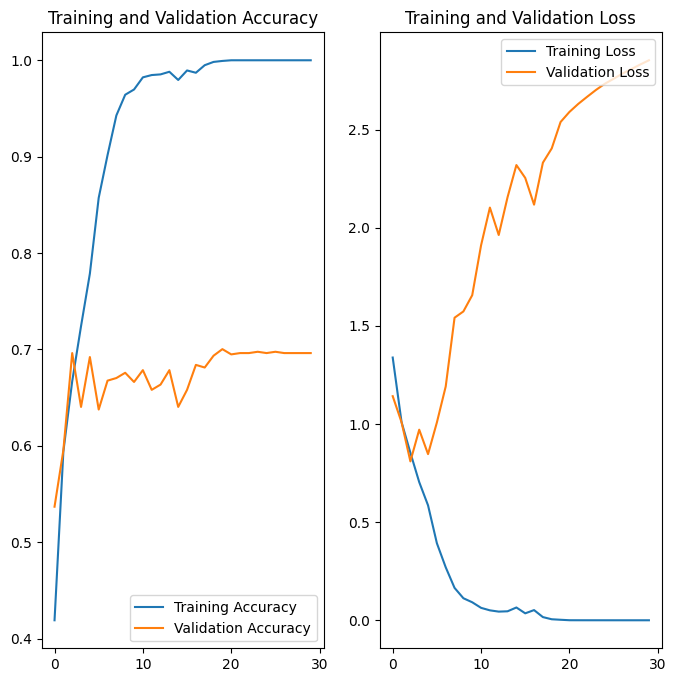

In [ ]:
#get train accuracy in history
acc = history.history['accuracy']
#get validation accuracy
val_acc = history.history['val_accuracy']
# get train loss
loss = history.history['loss']
#get validation loss
val_loss = history.history['val_loss']

epochs_range = range(epochs)
# plot accuracy
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
# plot loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Data Augmentation

Overfitting generally occurs when we have small number of training examples. One way to fix this problem is to augment our dataset so that it has sufficient number of training examples. Data augmentation takes the approach of generating more training data from existing training samples, by augmenting the samples via a number of random transformations that yield believable-looking images. The goal is that at training time, your model will never see the exact same picture twice. This helps expose the model to more aspects of the data and generalize better.



In [ ]:
# create augmentation sequentions
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.15),
    layers.RandomZoom(0.25),
  ]
)

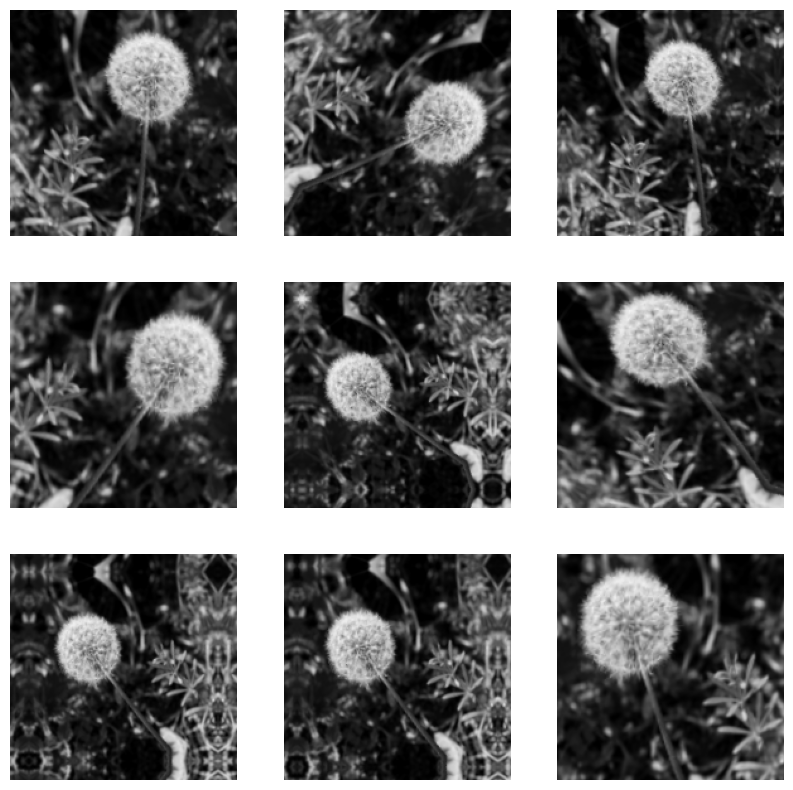

In [ ]:
plt.figure(figsize=(10, 10))
#take second image in train dataset
for images, _ in train_ds.take(2):
  for i in range(9):
    #implement augmentation
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [ ]:
# get class names
num_classes = len(class_names)

model = tf.keras.models.Sequential([
    tf.keras.layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),

    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(num_classes)])

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 90, 90, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_13 (Conv2D)          (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 45, 45, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_14 (Conv2D)          (None, 45, 45, 128)      

In [ ]:
epochs = 50
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50
92/92 [==============================] - 8s 61ms/step - loss: 1.3324 - accuracy: 0.4230 - val_loss: 1.0467 - val_accuracy: 0.5668
Epoch 2/50
92/92 [==============================] - 5s 59ms/step - loss: 1.0009 - accuracy: 0.5971 - val_loss: 0.9362 - val_accuracy: 0.6362
Epoch 3/50
92/92 [==============================] - 5s 58ms/step - loss: 0.8544 - accuracy: 0.6659 - val_loss: 0.8632 - val_accuracy: 0.6553
Epoch 4/50
92/92 [==============================] - 5s 58ms/step - loss: 0.7573 - accuracy: 0.7050 - val_loss: 0.7701 - val_accuracy: 0.6962
Epoch 5/50
92/92 [==============================] - 5s 58ms/step - loss: 0.6266 - accuracy: 0.7592 - val_loss: 0.8525 - val_accuracy: 0.6812
Epoch 6/50
92/92 [==============================] - 5s 58ms/step - loss: 0.4987 - accuracy: 0.8151 - val_loss: 0.9028 - val_accuracy: 0.6717
Epoch 7/50
92/92 [==============================] - 5s 58ms/step - loss: 0.4014 - accuracy: 0.8488 - val_loss: 0.8526 - val_accuracy: 0.7098
Epoch 8/50
92

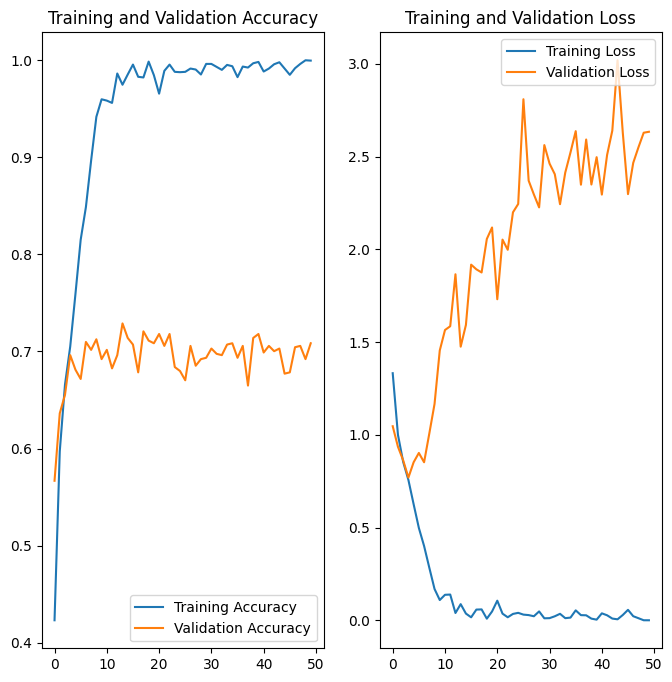

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
#image url
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
#dowload image
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)
#load image
img = tf.keras.utils.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
# image to array
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

#make prediction
predictions = model.predict(img_array)
#get score
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)